# Try out CNN on averaged EEG data

## Pre-processing
+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.
+ Average over a number of randomly drawn epochs (of same person and same stimuli).

## Train CNN network
+ Define network architecture
+ Split data
+ Train model


## Import packages & links

In [1]:
# Import packages
import os
import sys
import csv
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import ROOT, PATH_CODE, PATH_DATA, PATH_OUTPUT, PATH_METADATA

import mne
#%matplotlib inline
#from mayavi import mlab

### Define data folder

In [3]:
PATH_CNTS = os.path.join(PATH_DATA, "41mnd mmn")
PATH_DATA_processed = os.path.join(PATH_DATA, 'processed_data_41mnd')

## Load pre-processed dataset
+ See notebook for preprocessing: ePODIUM_prepare_data_for_ML.ipynb.ipynb

In [4]:
dirs = os.listdir(PATH_DATA_processed)
files_npy = fnmatch.filter(dirs, "*.npy")
files_csv = fnmatch.filter(dirs, "*.csv")

In [5]:
len(files_csv), len(files_npy)

(256, 256)

### Count the (main) labels for all present files

In [6]:
def read_labels(filename, PATH):
    metadata = []
    filename = os.path.join(PATH, filename)
    with open(filename, 'r') as readFile:
        reader = csv.reader(readFile, delimiter=',')
        for row in reader:
            #if len(row) > 0:
            metadata.append(row)
    readFile.close()
    
    return metadata[0]

In [7]:
label_collection = []
label_counts = []

for filename in files_csv:
    y_EEG = read_labels(filename, PATH_DATA_processed)
    labels_unique = list(set(y_EEG))
    label_collection.append(labels_unique)
    
    # Count instances for each unique label
    label_count = []
    for label in labels_unique:
        idx = np.where(np.array(y_EEG) == label)[0]
        label_count.append(len(idx))
    label_counts.append(label_count)

In [184]:
label_counts[:10], len(label_collection)

([[94, 763, 94],
  [99, 786, 99],
  [87, 687, 88],
  [75, 653, 77],
  [89, 707, 83],
  [138, 554],
  [145, 582],
  [149, 599],
  [149, 592],
  [48, 196]],
 256)

In [8]:
def transform_label(label,
                   label_dict,
                   main_label_dict = None):
    if label in label_dict:
        label_new = label_dict[label]
    else:
        label_new = None
    
    if main_label_dict is not None:
        if label in main_label_dict:
            main_label = main_label_dict[label]
        else:
            main_label = None
        return label_new, main_label
    
    else:
        return label_new
    

### Define new labels

In [57]:
label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '1',
    '66dys0_risk0': '2',
    '3dys0_risk1': '0',
    '13dys0_risk1': '1',
    '66dys0_risk1': '2',
    '3dys1_risk0': '3',
    '13dys1_risk0': '4',
    '66dys1_risk0': '5',
    '3dys1_risk1': '3',
    '13dys1_risk1': '4',
    '66dys1_risk1': '5',
}


main_label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '0',
    '66dys0_risk0': '0',
    '3dys0_risk1': '0',
    '13dys0_risk1': '0',
    '66dys0_risk1': '0',
    '3dys1_risk0': '1',
    '13dys1_risk0': '1',
    '66dys1_risk0': '1',
    '3dys1_risk1': '1',
    '13dys1_risk1': '1',
    '66dys1_risk1': '1',
}
"""
main_label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '0',
    '66dys0_risk0': '0',
    '3dys0_risk1': '1',
    '13dys0_risk1': '1',
    '66dys0_risk1': '1',
    '3dys1_risk0': '0',
    '13dys1_risk0': '0',
    '66dys1_risk0': '0',
    '3dys1_risk1': '1',
    '13dys1_risk1': '1',
    '66dys1_risk1': '1',
}
"""

"\nmain_label_dict  = {\n    '3dys0_risk0': '0',\n    '13dys0_risk0': '0',\n    '66dys0_risk0': '0',\n    '3dys0_risk1': '1',\n    '13dys0_risk1': '1',\n    '66dys0_risk1': '1',\n    '3dys1_risk0': '0',\n    '13dys1_risk0': '0',\n    '66dys1_risk0': '0',\n    '3dys1_risk1': '1',\n    '13dys1_risk1': '1',\n    '66dys1_risk1': '1',\n}\n"

### Collect main labels (here: dyslexic 0 | 1)

In [163]:
main_labels = [transform_label(x[0], label_dict, main_label_dict)[1] for x in label_collection]
len(main_labels)

256

In [164]:
for label in list(set(main_labels)):
    print("Found datapoints for label", label, "--->", main_labels.count(label))

Found datapoints for label 0 ---> 90
Found datapoints for label 1 ---> 166


## Import and initiate data generator function

In [14]:
from dataset_generator import DataGenerator

In [15]:
files_csv[:5]

['processed_data_003_41_jc_mmn36_wk.csv',
 'processed_data_005_41_jc_mmn36_mixed.csv',
 'processed_data_007_41_jc_mmn36_wk.csv',
 'processed_data_008_41_jc_mmn36_wk.csv',
 'processed_data_009_41_jc_mmn36_slp.csv']

### Split data set

In [165]:
np.random.seed(1098)
split_ratio = (0.7, 0.15, 0.15)

IDs_train = []
IDs_val = []
IDs_test = []

for label in list(set(main_labels)):
    idx = np.where(np.array(main_labels) == label)[0]
    N_label = len(idx)
    print("Found", N_label, "datapoints for label", label)
    
    N_train = int(split_ratio[0] * N_label)
    N_val = int(split_ratio[1] * N_label)
    N_test = N_label - N_train - N_val
    print("Split dataset for label", label, "into train/val/test fractions:", N_train, N_val, N_test)
    
    # Select training, validation, and test IDs:
    trainIDs = np.random.choice(idx, N_train, replace=False)
    valIDs = np.random.choice(list(set(idx) - set(trainIDs)), N_val, replace=False)
    testIDs = list(set(idx) - set(trainIDs) - set(valIDs))
    
    IDs_train.extend(list(trainIDs))
    IDs_val.extend(list(valIDs))
    IDs_test.extend(list(testIDs))

Found 90 datapoints for label 0
Split dataset for label 0 into train/val/test fractions: 62 13 15
Found 166 datapoints for label 1
Split dataset for label 1 into train/val/test fractions: 116 24 26


In [166]:
print(IDs_test)

[122, 202, 12, 187, 14, 204, 110, 124, 19, 116, 21, 26, 27, 28, 191, 144, 145, 148, 152, 42, 44, 46, 174, 175, 49, 51, 52, 179, 54, 183, 66, 74, 86, 89, 224, 98, 227, 102, 106, 234, 244]


In [167]:
print(IDs_train)

[185, 210, 132, 3, 200, 112, 201, 17, 7, 138, 126, 207, 131, 20, 194, 186, 1, 133, 184, 123, 198, 203, 109, 111, 115, 209, 158, 4, 18, 120, 118, 9, 128, 125, 188, 246, 129, 16, 192, 25, 205, 247, 24, 8, 127, 135, 11, 107, 208, 190, 108, 2, 22, 113, 10, 5, 211, 134, 6, 15, 119, 13, 82, 68, 181, 252, 213, 171, 223, 67, 229, 37, 153, 93, 43, 99, 80, 38, 226, 243, 79, 95, 84, 245, 230, 35, 139, 36, 155, 160, 147, 88, 240, 222, 236, 216, 75, 220, 218, 239, 87, 166, 176, 55, 162, 45, 157, 90, 30, 143, 215, 254, 96, 141, 50, 163, 225, 29, 101, 182, 168, 249, 212, 76, 41, 103, 151, 72, 150, 167, 251, 161, 250, 97, 180, 228, 78, 32, 59, 164, 165, 81, 104, 105, 47, 233, 57, 63, 136, 40, 92, 137, 71, 237, 33, 94, 156, 235, 61, 219, 217, 48, 91, 242, 39, 56, 241, 85, 169, 178, 253, 140, 73, 177, 173, 172, 149, 170]


In [153]:
label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '0',
    '66dys0_risk0': '0',
    '3dys0_risk1': '1',
    '13dys0_risk1': '1',
    '66dys0_risk1': '1',
    '3dys1_risk0': '0',
    '13dys1_risk0': '0',
    '66dys1_risk0': '0',
    '3dys1_risk1': '1',
    '13dys1_risk1': '1',
    '66dys1_risk1': '1',
}

main_label_dict = label_dict.copy()

binarizer_dict  = {
    '0': [1,0],
    '1': [0,1]
}

In [123]:
label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '0',
    '66dys0_risk0': '0',
    '3dys0_risk1': '0',
    '13dys0_risk1': '0',
    '66dys0_risk1': '0',
    '3dys1_risk0': '1',
    '13dys1_risk0': '1',
    '66dys1_risk0': '1',
    '3dys1_risk1': '1',
    '13dys1_risk1': '1',
    '66dys1_risk1': '1',
}

binarizer_dict  = {
    '0': [1,0],
    '1': [0,1]
}

"""
binarizer_dict  = {
    '0': [0],
    '1': [1]
}
"""

"\nbinarizer_dict  = {\n    '0': [0],\n    '1': [1]\n}\n"

In [19]:
label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '1',
    '66dys0_risk0': '2',
    '3dys0_risk1': '0',
    '13dys0_risk1': '1',
    '66dys0_risk1': '2',
    '3dys1_risk0': '3',
    '13dys1_risk0': '4',
    '66dys1_risk0': '5',
    '3dys1_risk1': '3',
    '13dys1_risk1': '4',
    '66dys1_risk1': '5',
}

binarizer_dict  = {
    '0': [1, 0, 0, 0, 0, 0],
    '1': [0, 1, 0, 0, 0, 0],
    '2': [0, 0, 1, 0, 0, 0],
    '3': [0, 0, 0, 1, 0, 0],
    '4': [0, 0, 0, 0, 1, 0],
    '5': [0, 0, 0, 0, 0, 1]
}

In [124]:
# give labels of data that should not be used for training/testing

ignore_labels = ['3dys0_risk0', '3dys0_risk1', '3dys1_risk0', '3dys1_risk1',
                '13dys0_risk0', '13dys0_risk1', '13dys1_risk0', '13dys1_risk1']

In [168]:
train_generator = DataGenerator(list_IDs = IDs_train,
                                 main_labels = main_labels,
                                 label_dict = label_dict,
                                 binarizer_dict = binarizer_dict,
                                 ignore_labels = ignore_labels,
                                 path_data = PATH_DATA_processed,
                                 filenames = [x[:-4] for x in files_csv],
                                 data_path = PATH_DATA_processed, 
                                 to_fit=True, 
                                 n_average = 40,
                                 batch_size = 32,
                                 iter_per_epoch = 50,
                                 up_sampling = True,
                                 n_timepoints = 501,
                                 n_channels=30, 
                                 shuffle=True)

val_generator = DataGenerator(list_IDs = IDs_val,
                                 main_labels = main_labels,
                                 label_dict = label_dict,
                                 binarizer_dict = binarizer_dict,
                                 ignore_labels = ignore_labels,
                                 path_data = PATH_DATA_processed,
                                 filenames = [x[:-4] for x in files_csv],
                                 data_path = PATH_DATA_processed, 
                                 to_fit=True, 
                                 n_average = 40,
                                 batch_size = 32,
                                 iter_per_epoch = 50,
                                 up_sampling = True,
                                 n_timepoints = 501,
                                 n_channels=30, 
                                 shuffle=True)

In [169]:
test_generator = DataGenerator(list_IDs = IDs_test,
                                 main_labels = main_labels,
                                 label_dict = label_dict,
                                 binarizer_dict = binarizer_dict,
                                 ignore_labels = ignore_labels,
                                 path_data = PATH_DATA_processed,
                                 filenames = [x[:-4] for x in files_csv],
                                 data_path = PATH_DATA_processed, 
                                 to_fit=True, 
                                 n_average = 40,
                                 batch_size = 100,
                                 iter_per_epoch = 10,
                                 up_sampling = True,
                                 n_timepoints = 501,
                                 n_channels=30, 
                                 n_classes=1, 
                                 shuffle=True)

In [170]:
X, y  = train_generator.__getitem__(1)

In [171]:
X.shape, len(y)

((9, 501, 30), 9)

In [172]:
print(y[:11])

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]]


In [173]:
np.sum(y, axis=0)

array([5, 4])

IndexError: index 9 is out of bounds for axis 0 with size 9

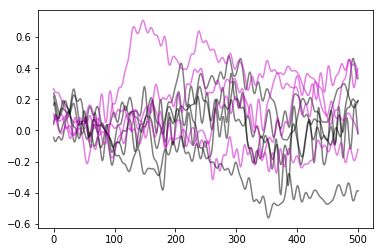

In [174]:
for i in range(10):
    label = 4*np.where(y[i] == 1)[0][0]
    #label = 4*y[i][0]
    plt.plot(X[i,:,2], alpha = 0.5, color=(label/5,0, label/5))

## Define model architecture

In [132]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers

In [175]:
# Simple CNN model
n_timesteps = 501
n_features = 30
n_outputs = 2 #6

model = tf.keras.Sequential()
model.add(layers.Conv1D(filters=48, kernel_size=20, input_shape=(n_timesteps,n_features)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

model.add(layers.Conv1D(filters=64, kernel_size=10)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

model.add(layers.Conv1D(filters=96, kernel_size=5)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(n_outputs, activation='softmax'))

#Adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
#model.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [137]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_79 (Conv1D)           (None, 482, 48)           28848     
_________________________________________________________________
batch_normalization_v1_37 (B (None, 482, 48)           192       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 482, 48)           0         
_________________________________________________________________
average_pooling1d_23 (Averag (None, 241, 48)           0         
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 232, 64)           30784     
_________________________________________________________________
batch_normalization_v1_38 (B (None, 232, 64)           256       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 232, 64)           0         
__________

In [176]:
# Save best model and include early stopping
output_filename = 'CNN_1D_classifier_avg_41mnd'
output_file = os.path.join(PATH_CODE, 'models_trained' , output_filename + "-{epoch:02d}-{val_acc:.2f}.hdf5")
checkpointer = ModelCheckpoint(filepath = output_file, 
                               monitor='val_acc', 
                               verbose=1, 
                               save_best_only=False)
earlystopper = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

model.fit_generator(generator=train_generator, 
                   validation_data=val_generator,
                   epochs=50,
                   callbacks = [
                       checkpointer, 
                        earlystopper,
                   ]
                  )

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.7275 - acc: 0.4286

Epoch 00001: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\CNN_1D_classifier_avg_41mnd-01-0.43.hdf5
5/5 [==============================] - 25s 5s/step - loss: 1.1039 - acc: 0.5957 - val_loss: 0.7275 - val_acc: 0.4286
Epoch 2/50
1/1 [==============================] - 6s 6s/step - loss: 0.6779 - acc: 0.5000

Epoch 00002: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\CNN_1D_classifier_avg_41mnd-02-0.50.hdf5
5/5 [==============================] - 16s 3s/step - loss: 1.0079 - acc: 0.6981 - val_loss: 0.6779 - val_acc: 0.5000
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.6966 - acc: 0.6000

Epoch 00003: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\CNN_1D_classifier_avg_41mnd-03-0.

In [177]:
X_test, y_test = test_generator.__getitem__(0)
# Check model predictions:
y_pred = model.predict(X_test)

In [178]:
print(np.argmax(y_pred, axis=1)[:30])
print(np.argmax(y_test, axis=1)[:30])

print("true: ", np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)))
print("false: ", np.sum(np.argmax(y_pred, axis=1) != np.argmax(y_test, axis=1)))

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 0]
true:  8
false:  12


## CNN with 2D convolution in between

In [68]:
# CNN model combining 1D and 2D convolutions:

n_timesteps = 501
n_features = 30
n_outputs = 2

model = tf.keras.Sequential()
model.add(layers.Conv1D(filters=48, kernel_size=20, input_shape=(n_timesteps,n_features)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

model.add(layers.Reshape((241, 48, 1)))
model.add(layers.Conv2D(filters=64, kernel_size=(10, 48)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Reshape((232, 64)))
model.add(layers.AveragePooling1D(pool_size=2))

#model.add(layers.Conv1D(filters=64, kernel_size=10)) #, activation='relu'))
#model.add(layers.BatchNormalization())
#model.add(layers.LeakyReLU())
#model.add(layers.AveragePooling1D(pool_size=2))

model.add(layers.Conv1D(filters=128, kernel_size=10)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=3))

#model.add(layers.Conv1D(filters=96, kernel_size=3, activation='relu'))
#model.add(layers.AveragePooling1D(pool_size=2))
#model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(n_outputs, activation='softmax'))

Adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 482, 48)           28848     
_________________________________________________________________
batch_normalization_v1_15 (B (None, 482, 48)           192       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 482, 48)           0         
_________________________________________________________________
average_pooling1d_15 (Averag (None, 241, 48)           0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 241, 48, 1)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 232, 1, 64)        30784     
_________________________________________________________________
batch_normalization_v1_16 (B (None, 232, 1, 64)        256       
__________

In [70]:
# Save best model and include early stopping
output_filename = 'CNN_1D_2D_classifier_avg_41mnd'
output_file = os.path.join(PATH_CODE, 'models_trained' , output_filename + "-{epoch:02d}-{val_acc:.2f}.hdf5")
checkpointer = ModelCheckpoint(filepath = output_file, 
                               monitor='val_acc', 
                               verbose=1, 
                               save_best_only=False)
earlystopper = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

model.fit_generator(generator=train_generator, 
                   validation_data=val_generator,
                   epochs=50,
                   callbacks = [
                       checkpointer, 
                        earlystopper,
                   ]
                  )

Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 0.6933 - acc: 0.5000

Epoch 00001: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\CNN_1D_2D_classifier_avg_41mnd-01-0.50.hdf5
5/5 [==============================] - 41s 8s/step - loss: 1.0178 - acc: 0.5024 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 2/50
1/1 [==============================] - 7s 7s/step - loss: 0.6946 - acc: 0.5238

Epoch 00002: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\CNN_1D_2D_classifier_avg_41mnd-02-0.52.hdf5
5/5 [==============================] - 27s 5s/step - loss: 0.7778 - acc: 0.5909 - val_loss: 0.6946 - val_acc: 0.5238
Epoch 3/50
1/1 [==============================] - 7s 7s/step - loss: 0.6932 - acc: 0.5250

Epoch 00003: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\CNN_1D_2D_classifier_avg_41

In [71]:
model.get_weights()

[array([[[-2.71895938e-02, -2.80009247e-02,  1.10774199e-02, ...,
          -4.96994406e-02, -2.28353334e-03, -3.11769708e-03],
         [ 5.85632995e-02,  3.10162604e-02, -4.63430546e-02, ...,
           5.80515824e-02, -5.02342321e-02,  5.15300110e-02],
         [ 4.18450497e-02,  5.79756647e-02, -5.88560924e-02, ...,
           1.84078682e-02, -1.42112011e-02,  2.12112721e-02],
         ...,
         [ 5.46004474e-02,  3.97293072e-04,  3.14258449e-02, ...,
          -2.97127049e-02,  5.64334318e-02, -2.38573905e-02],
         [ 4.46813814e-02,  4.09542359e-02,  4.56419401e-02, ...,
          -4.94259745e-02,  6.50181901e-05,  1.85325518e-02],
         [ 2.16930881e-02,  1.91004463e-02, -2.60004811e-02, ...,
          -3.76578011e-02,  1.54768443e-02, -1.16185108e-02]],
 
        [[-5.49352951e-02, -2.68999469e-02, -5.24260364e-02, ...,
          -3.49138677e-03,  1.81436893e-02,  1.75459951e-03],
         [ 1.81489717e-02,  7.35449838e-03,  7.83401448e-03, ...,
           2.71730591

In [73]:
X_test, y_test = test_generator.__getitem__(0)

In [74]:
X_test.shape, y_test.shape

((235, 501, 30), (235, 2))

In [75]:
np.sum(y_test, axis=0)

array([125, 110])

In [76]:
# Check model predictions:
y_pred = model.predict(X_test)

In [77]:
y_pred[:10]

array([[0.5145836 , 0.48541644],
       [0.5100339 , 0.4899661 ],
       [0.5185583 , 0.48144165],
       [0.5175312 , 0.48246878],
       [0.5171035 , 0.48289648],
       [0.51478505, 0.48521498],
       [0.51190424, 0.48809567],
       [0.51930225, 0.4806977 ],
       [0.51087904, 0.48912096],
       [0.51399434, 0.48600557]], dtype=float32)

In [151]:
y_pred_inception[:10]

array([[0.7187703 , 0.2812297 ],
       [0.9493008 , 0.0506992 ],
       [0.4453468 , 0.55465317],
       [0.632294  , 0.36770603],
       [0.34691966, 0.65308034],
       [0.2078207 , 0.7921793 ],
       [0.8458051 , 0.15419492],
       [0.9105229 , 0.08947717],
       [0.8676915 , 0.1323085 ],
       [0.9788207 , 0.02117923]], dtype=float32)

In [78]:
print(np.argmax(y_pred, axis=1)[:30])
print(np.argmax(y_test, axis=1)[:30])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0]


In [79]:
print(np.argmax(y_pred, axis=1)[:30])
print(np.argmax(y_test, axis=1)[:30])

print("true: ", np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)))
print("false: ", np.sum(np.argmax(y_pred, axis=1) != np.argmax(y_test, axis=1)))

true:  125
false:  110


In [53]:
# Calculate accuracy
from sklearn import metrics

In [54]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.utils.multiclass import unique_labels
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    ## Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


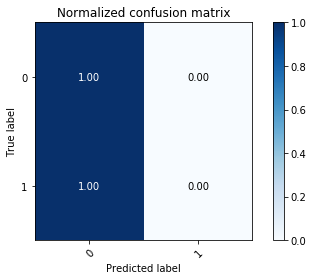

In [80]:
# Plot normalized confusion matrix
labels = list(binarizer_dict.keys())

plot_confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(y_pred, axis=1), 
                      classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion_matrix123.pdf')

Normalized confusion matrix
[[0.         0.98181818 0.         0.         0.01818182 0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]]


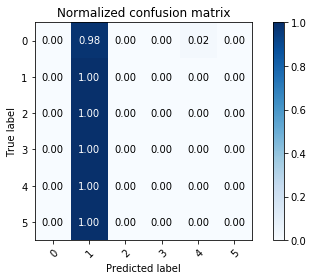

In [56]:
# Plot normalized confusion matrix
labels = list(binarizer_dict.keys())

plot_confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(y_pred, axis=1), 
                      classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion_matrix123.pdf')

# Alternative architecture: InceptionTime

In [81]:
from inception_time import InceptionTime

In [82]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

class InceptionTime:

    def __init__(self, 
                 output_directory, 
                 input_shape, 
                 nb_classes, 
                 verbose=False, 
                 build=True, 
                 batch_size=64,
                 nb_filters=32, 
                 use_residual=True, 
                 use_bottleneck=True, 
                 depth=6, 
                 kernel_size=41, 
                 nb_epochs=1500,
                 binarize_2_to_1 = False):
        """
        
        """

        self.output_directory = output_directory
        self.input_shape = input_shape
        self.nb_classes = nb_classes
        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs
        self.binarize_2_to_1 = binarize_2_to_1

        if build == True:
            self.model = self.build_model()
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose
            self.model.save_weights(self.output_directory + 'model_init.hdf5')


    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = layers.Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                                  padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        # kernel_size_s = [3, 5, 8, 11, 17]
        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(layers.Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                                 strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = layers.Conv1D(filters=self.nb_filters, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = layers.Concatenate(axis=2)(conv_list)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation='relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                         padding='same', use_bias=False)(input_tensor)
        shortcut_y = layers.BatchNormalization()(shortcut_y)

        x = layers.Add()([shortcut_y, out_tensor])
        x = layers.Activation('relu')(x)
        return x

    def build_model(self):
        input_layer = layers.Input(self.input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer_pool = layers.AveragePooling1D(pool_size=10)(x)
        gap_layer = layers.Flatten()(gap_layer_pool)
        
        final_dense = layers.Dense(50, activation='relu')(gap_layer)
        
        #gap_layer = layers.GlobalAveragePooling1D()(x)
        
        if self.nb_classes == 2 and self.binarize_2_to_1:
            output_layer = layers.Dense(1, activation='softmax')(final_dense)
        else:
            output_layer = layers.Dense(self.nb_classes, activation='softmax')(final_dense)

        model = Model(inputs=input_layer, outputs=output_layer)

        if self.nb_classes == 2 and self.binarize_2_to_1:
            model.compile(loss='binary_crossentropy', 
                          optimizer=optimizers.Adam(),
                          metrics=['accuracy'])
        else:
            model.compile(loss='categorical_crossentropy', 
                          optimizer=optimizers.Adam(),
                          metrics=['accuracy'])

        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50,
                                                      min_lr=0.0001)

        file_path = self.output_directory + 'best_model.hdf5'

        model_checkpoint = ModelCheckpoint(filepath=file_path, monitor='loss',
                                                           save_best_only=True)

        self.callbacks = [reduce_lr, model_checkpoint]

        return model

In [83]:
inception_model = InceptionTime(output_directory = os.path.join(PATH_CODE, 'models_trained'), 
                                 input_shape = (501,30), 
                                 nb_classes = 2, 
                                 verbose=False, 
                                 build=True, 
                                 batch_size=64,
                                 nb_filters=32, 
                                 use_residual=True, 
                                 use_bottleneck=True, 
                                 depth=6, 
                                 kernel_size=41, 
                                 nb_epochs=1500)

In [84]:
model_inception = inception_model.build_model() 
model_inception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 501, 30)      0                                            
__________________________________________________________________________________________________
conv1d_44 (Conv1D)              (None, 501, 32)      960         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 501, 30)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 501, 32)      40960       conv1d_44[0][0]                  
__________________________________________________________________________________________________
conv1d_46 

In [85]:
# Save best model and include early stopping
output_filename = 'InceptionTime_deep_classifier_avg_41mnd'
output_file = os.path.join(PATH_CODE, 'models_trained' , output_filename + "-{epoch:02d}-{val_acc:.2f}.hdf5")
checkpointer = ModelCheckpoint(filepath = output_file, 
                               monitor='val_acc', 
                               verbose=1, 
                               save_best_only=False)
earlystopper = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

model_inception.fit_generator(generator=train_generator, 
                           validation_data=val_generator,
                           epochs=50,
                           callbacks = [
                                        checkpointer, 
                                        earlystopper,
                   ]
                  )

Epoch 1/50
1/1 [==============================] - 11s 11s/step - loss: 0.6710 - acc: 0.5750

Epoch 00001: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\InceptionTime_deep_classifier_avg_41mnd-01-0.57.hdf5
5/5 [==============================] - 73s 15s/step - loss: 2.2092 - acc: 0.4952 - val_loss: 0.6710 - val_acc: 0.5750
Epoch 2/50
1/1 [==============================] - 8s 8s/step - loss: 0.4578 - acc: 0.7632

Epoch 00002: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\InceptionTime_deep_classifier_avg_41mnd-02-0.76.hdf5
5/5 [==============================] - 35s 7s/step - loss: 0.6741 - acc: 0.5953 - val_loss: 0.4578 - val_acc: 0.7632
Epoch 3/50
1/1 [==============================] - 9s 9s/step - loss: 0.8568 - acc: 0.5263

Epoch 00003: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\Incept

In [108]:
model_file = os.path.join(PATH_CODE, 'models_trained', 'InceptionTime_deep_classifier_avg_41mnd-05-0.67.hdf5')
model_inception.load_weights(model_file)

In [114]:
test_generator = DataGenerator(list_IDs = IDs_test,
                                 main_labels = main_labels,
                                 label_dict = label_dict,
                                 binarizer_dict = binarizer_dict,
                                 ignore_labels = ignore_labels,
                                 path_data = PATH_DATA_processed,
                                 filenames = [x[:-4] for x in files_csv],
                                 data_path = PATH_DATA_processed, 
                                 to_fit=True, 
                                 n_average = 50,
                                 batch_size = 200,
                                 iter_per_epoch = 10,
                                 up_sampling = True,
                                 n_timepoints = 501,
                                 n_channels=30, 
                                 n_classes=1, 
                                 shuffle=True)

In [115]:
X, y  = test_generator.__getitem__(0)

In [116]:
X.shape, y.shape

((230, 501, 30), (230, 2))

In [117]:
y[:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1]])

In [118]:
# Check model predictions:
y_pred = model_inception.predict(X)

In [119]:
y_pred[:10]

array([[0.3341584 , 0.6658416 ],
       [0.344618  , 0.65538204],
       [0.2576775 , 0.7423225 ],
       [0.37759927, 0.6224007 ],
       [0.52407193, 0.475928  ],
       [0.62919545, 0.37080455],
       [0.6231958 , 0.37680414],
       [0.39207152, 0.60792845],
       [0.78660256, 0.21339749],
       [0.8493071 , 0.15069288]], dtype=float32)

In [120]:
print(np.argmax(y_pred, axis=1)[:30])
print(np.argmax(y, axis=1)[:30])

[1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1]
[0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0]


In [121]:
print("true: ", np.sum(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)))
print("false: ", np.sum(np.argmax(y_pred, axis=1) != np.argmax(y, axis=1)))

true:  119
false:  111


Normalized confusion matrix
[[0.35338346 0.64661654]
 [0.25773196 0.74226804]]


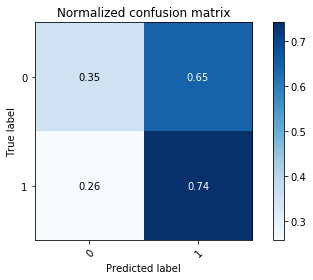

In [122]:
# Plot normalized confusion matrix
labels = list(binarizer_dict.keys())

plot_confusion_matrix(np.argmax(y, axis=1), 
                      np.argmax(y_pred, axis=1), 
                      classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion_matrix123.pdf')